Dodajemy importy

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier

Wczytanie danych z separatorem ","

In [2]:
df = pd.read_csv("./loan_data.csv", sep=",")

Wyświetlenie danych

In [3]:
print(df)

       person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   O

Wyświetalnie dodatkowych informacji

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
pd.set_option("display.max_columns",None)

Zmieniamy typ na int gdyż nie potrzebujemy floatow

In [6]:
df["person_age"] = df["person_age"].astype(int)
df["cb_person_cred_hist_length"] = df["cb_person_cred_hist_length"].astype(int)

In [7]:
before_length = len(df)

Wyswietlamy unikalne wartosci dla każdej kolumny

In [8]:
for column in df.columns:
    print(column + ": ", df[column].unique())

person_age:  [ 22  21  25  23  24  26 144 123  20  32  34  29  33  28  35  31  27  30
  36  40  50  45  37  39  44  43  41  46  38  47  42  48  49  58  65  51
  53  66  61  54  57  59  62  60  55  52  64  70  78  69  56  73  63  94
  80  84  76  67 116 109]
person_gender:  ['female' 'male']
person_education:  ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
person_income:  [71948. 12282. 12438. ... 31924. 56942. 33164.]
person_emp_exp:  [  0   3   1   5   4   2   7   6 125   8 121 101 100  12  10   9  14  13
  11  15  16  17  19  28  25  18  24  22  20  23  21  31  26  27  29  32
  30 124  40  43  33  44  34  42  37  45  36  41  47  38  39  35  57  46
  49  48  50  76  62  61  58  93  85]
person_home_ownership:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_amnt:  [35000.  1000.  5500. ... 12229.  2771.  6665.]
loan_intent:  ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_int_rate:  [16.02 11.14 12.87 ... 19.11 19.8  16.92]
loan_percent_inco

Sprawdzamy czy nie ma takich rekordów, którzy więcej pracowali lub mieli dłuższą historie kredytową niż ich długość życia

In [9]:
found = False
for index, row in df.iterrows():
    if row["person_age"] < row["person_emp_exp"]:
        found = True
        break
    if row["person_age"] < row["cb_person_cred_hist_length"]:
        found = True
        break
if found:
    print("Są takie obserwacje, których czas pracy lub dlugość historii kredytowej jest większa niż długość życia")
else:
    print("Nie ma obserwacji, których czas pracy lub dlugość historii kredytowej jest większa niż długość życia")

Nie ma obserwacji, których czas pracy lub dlugość historii kredytowej jest większa niż długość życia


Sprawdzamy czy są duplikaty

In [10]:
print("Ilość duplikatów - ", len(df[df.duplicated()]))

Ilość duplikatów -  0


Usuwamy obserwacje gdzie wiek jest powyżej 100 lat

In [11]:
df = df[df["person_age"] <= 100]
print("Usunięto ", before_length - len(df), " wyników, gdzie wiek większy niż 100")

Usunięto  7  wyników, gdzie wiek większy niż 100


Służy nam do wyznaczenia podstawowych statystyk

In [12]:
print(df.describe())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  44993.000000   4.499300e+04    44993.000000  44993.000000   
mean      27.748428   7.990845e+04        5.394528   9583.176761   
std        5.909737   6.332213e+04        5.927159   6314.802655   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.719500e+04        1.000000   5000.000000   
50%       26.000000   6.704600e+04        4.000000   8000.000000   
75%       30.000000   9.577800e+04        8.000000  12237.000000   
max       94.000000   2.448661e+06       76.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   44993.000000         44993.000000                44993.000000   
mean       11.006448             0.139736                    5.866557   
std         2.978985             0.087207                    3.877167   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

Sprawdzamy jakiej częsci osób został udzielony kredyt

In [13]:
print(df["loan_status"].value_counts(normalize = True))

loan_status
0    0.777743
1    0.222257
Name: proportion, dtype: float64


Sprawdzmy czy są jakieś zależności, między zmiennymi

person_gender    female      male
loan_status                      
0              0.777497  0.777943
1              0.222503  0.222057
person_education  Associate  Bachelor  Doctorate  High School    Master
loan_status                                                            
0                  0.779644  0.774709   0.771337     0.776859  0.782378
1                  0.220356  0.225291   0.228663     0.223141  0.217622
previous_loan_defaults_on_file        No  Yes
loan_status                                  
0                               0.548268  1.0
1                               0.451732  0.0


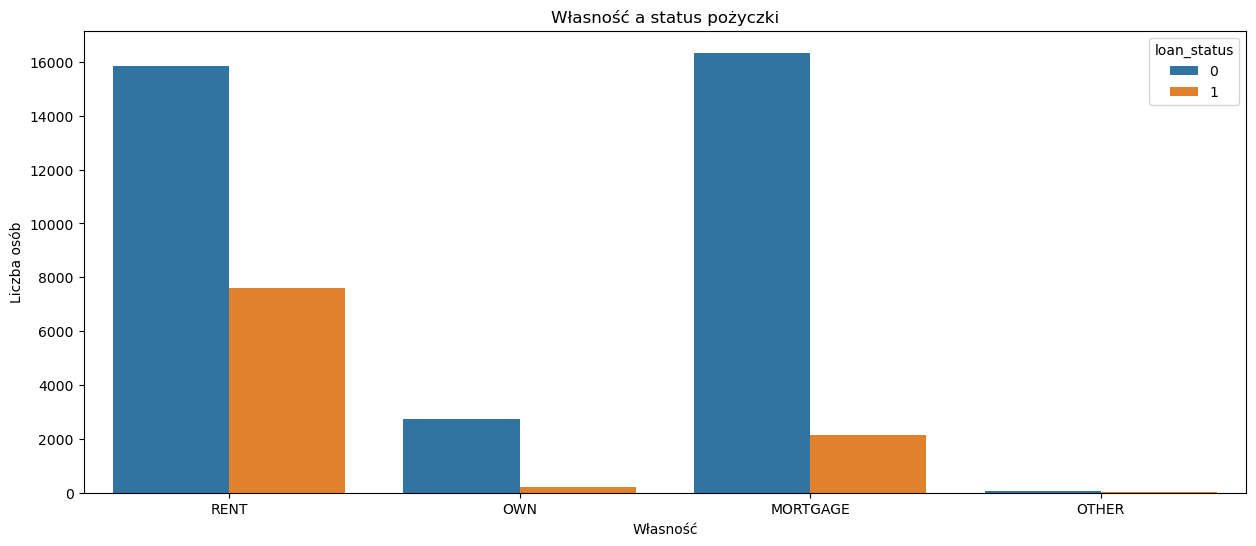

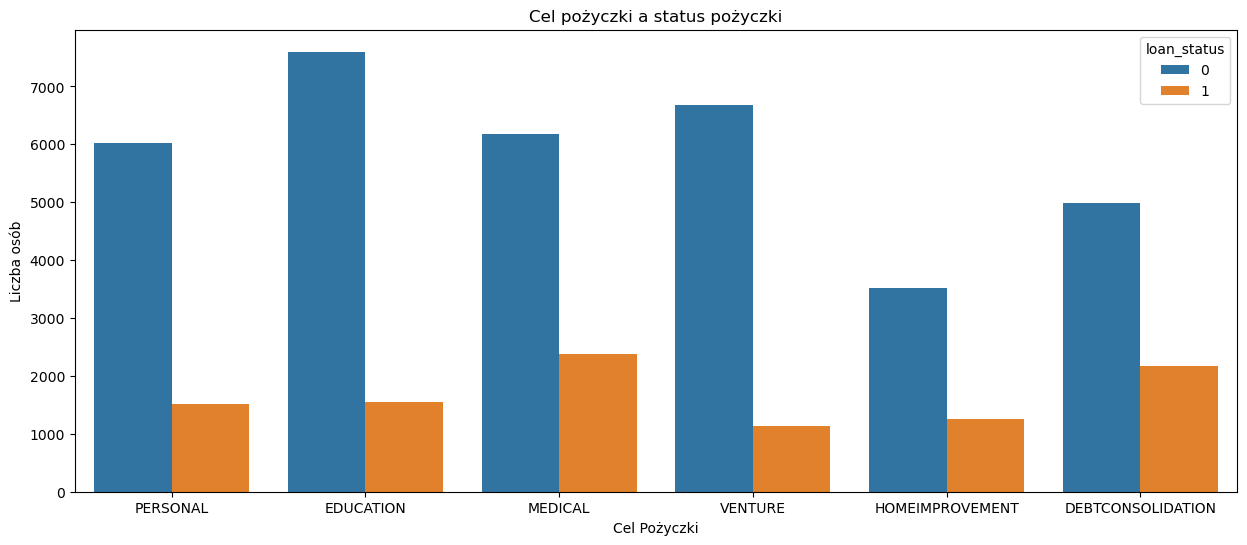

In [14]:
print(pd.crosstab(df["loan_status"], df["person_gender"], normalize="columns"))
print(pd.crosstab(df["loan_status"], df["person_education"], normalize="columns"))
print(pd.crosstab(df["loan_status"], df["previous_loan_defaults_on_file"], normalize = "columns"))

plt.figure(figsize=(15, 6))
sns.countplot(x='person_home_ownership', hue='loan_status', data=df)
plt.title('Własność a status pożyczki')
plt.xlabel('Własność')
plt.ylabel('Liczba osób')
plt.show()

plt.figure(figsize=(15, 6))
sns.countplot(x='loan_intent', hue='loan_status', data=df)
plt.title('Cel pożyczki a status pożyczki')
plt.xlabel('Cel Pożyczki')
plt.ylabel('Liczba osób')
plt.show()

Obliczamy korelacje

In [15]:
print("Korelacja: ", (df["loan_amnt"] * 100 / df["person_income"]).corr(df["loan_percent_income"]))

Korelacja:  0.999445497695405


Sprawdzamy zależności między zmiennymi liczbowymi

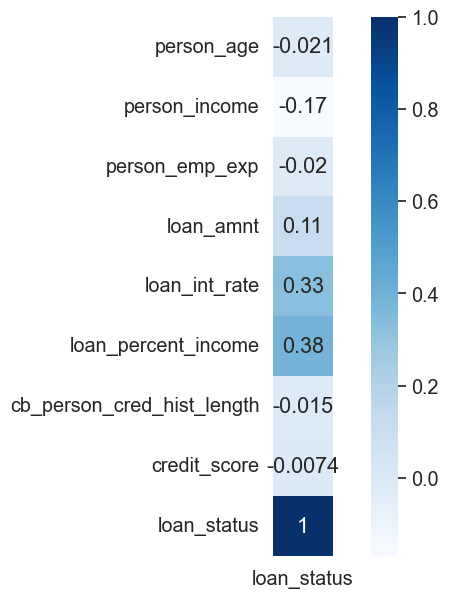

In [16]:
plt.figure(figsize=(10,7))
sns.set_theme(font_scale = 1.3)
sns.heatmap(df.select_dtypes(include="number").corr()["loan_status"].to_frame(), cbar = True, annot = True, square = True, cmap = "Blues")
plt.show()

Odrzucamy możliwe nieznaczące zmienne

In [17]:
df = df.drop(["person_gender", "person_education", "loan_percent_income", "person_age", "person_emp_exp", "cb_person_cred_hist_length", "credit_score"], axis=1)

Wyciągamy predytkory oraz zmienne celu

In [18]:
y = df["loan_status"]
X = df.drop(["loan_status"], axis=1)

Dzielimy na zbiór uczący i testowy

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 313128)

Dzielimy zmienne na numeryczne i kategoryczne

In [20]:
sel_num = make_column_selector(dtype_include=["int64", "float64"])
sel_cat = make_column_selector(dtype_include="object")

# Sieci neurnowe
Zmienne numeryczne normalizujemy, a z katogrycznymi dzielimy na osobne kolumny dla kazdej wartości

In [21]:
preprocessor = ColumnTransformer(transformers =
                                [("num", MinMaxScaler(feature_range = (0, 1)), sel_num),
                                 ("cat", OneHotEncoder(handle_unknown = "ignore"), sel_cat)])

Tworzymy potok, który na początku wykona preprocessor, który utworzyliśmy wyżej a potem juz klasyfikator oparty o sieci neuronowe, parametry zostały dobrane dzięki grid search

In [22]:
pipeline = Pipeline(steps = [("prep", preprocessor),
                        ("siec", MLPClassifier(random_state=313128, max_iter=1000, hidden_layer_sizes=(50, 50)))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015CB324AA20>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015CB318FC20>)])),
                ('siec',
                 MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000,
                               random_state=313128))])

Uzyskujemy trafność modelu

In [23]:
print("Trafność: ")
print("Zbiór uczący: ", pipeline.score(X_train, y_train))
print("Zbiór testowy: ", pipeline.score(X_test, y_test))

Trafność: 
Zbiór uczący:  0.9203365613589458
Zbiór testowy:  0.9193954659949622


Uzyskujemy macierze pomylek dla uczącej i testowej

In [24]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Macierze pomyłek: ")
print("Zbiór uczący: ")
print(pd.DataFrame(confusion_matrix_test))
print("Zbiór testowy: ")
print(pd.DataFrame(confusion_matrix_train))

Macierze pomyłek: 
Zbiór uczący: 
       0     1
0  10109   330
1    758  2301
Zbiór testowy: 
       0     1
0  23776   778
1   1731  5210


Wyznaczamy tp, tn, fp, fn

In [25]:
tn_train, fp_train, fn_train, tp_train = confusion_matrix_train.ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix_test.ravel()

uzyskujemy czułość modelu

In [27]:
sensitivity_train = tp_train/(tp_train + fn_train)
sensitivity_test = tp_test/(tp_test + fn_test)
print("Czułość: ")
print("Zbiór uczący: ", sensitivity_train)
print("Zbiór testowy: ", sensitivity_test)

Czułość: 
Zbiór uczący:  0.7506123037026365
Zbiór testowy:  0.7522066034651848


Uzyskujemy swoistość modelu

In [28]:
print("Swoistość: ")
print("Zbiór uczący: ", tn_train/(tn_train + fp_train))
print("Zbiór testowy: ", tn_test/(tn_test + fp_test))

Swoistość: 
Zbiór uczący:  0.9683147348700822
Zbiór testowy:  0.9683877766069547


Uzyskujemy precyzje modelu

In [29]:
precision_train = tp_train/(tp_train + fp_train)
precision_test = tp_test/(tp_test + fp_test)
print("Precyzja: ")
print("Zbiór uczący: ", precision_train)
print("Zbiór testowy: ", precision_test)

Precyzja: 
Zbiór uczący:  0.8700734802939212
Zbiór testowy:  0.8745724059293044


Uzyskujemy f1 modelu

In [30]:
print("F1: ")
print("Zbiór uczący: ", 2*sensitivity_train*precision_train/(sensitivity_train + precision_train))
print("Zbiór testowy: ", 2*sensitivity_test*precision_test/(sensitivity_test + precision_test))

F1: 
Zbiór uczący:  0.8059401345811741
Zbiór testowy:  0.8087873462214411


Uzyskujemy krzywą roc wraz z auc dla zbioru uczącego

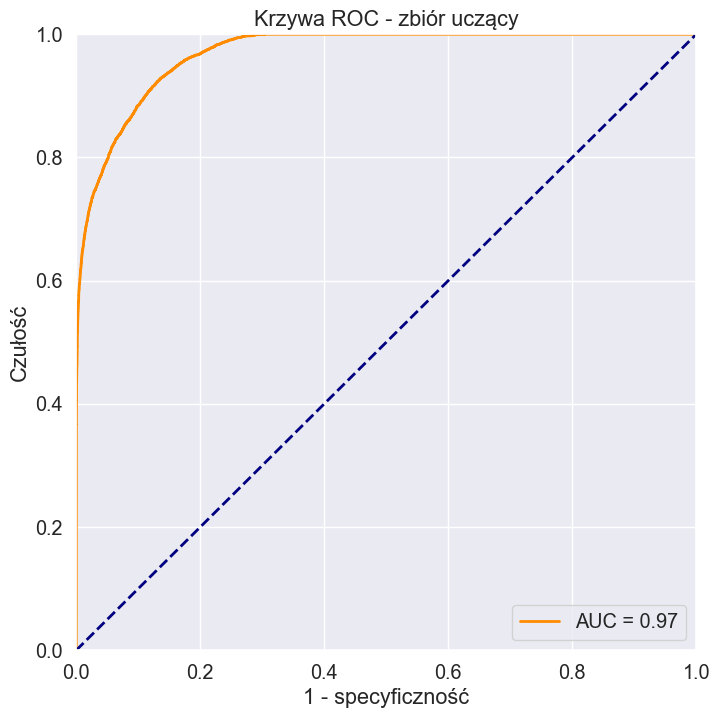

In [31]:
y_train_prob = pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label = 1)
auc = roc_auc_score(y_train, y_train_prob)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - specyficzność')
plt.ylabel('Czułość')
plt.title('Krzywa ROC - zbiór uczący')
plt.legend(loc="lower right")
plt.show()

Uzyskujemy krzywą roc wraz z auc dla zbioru testowego

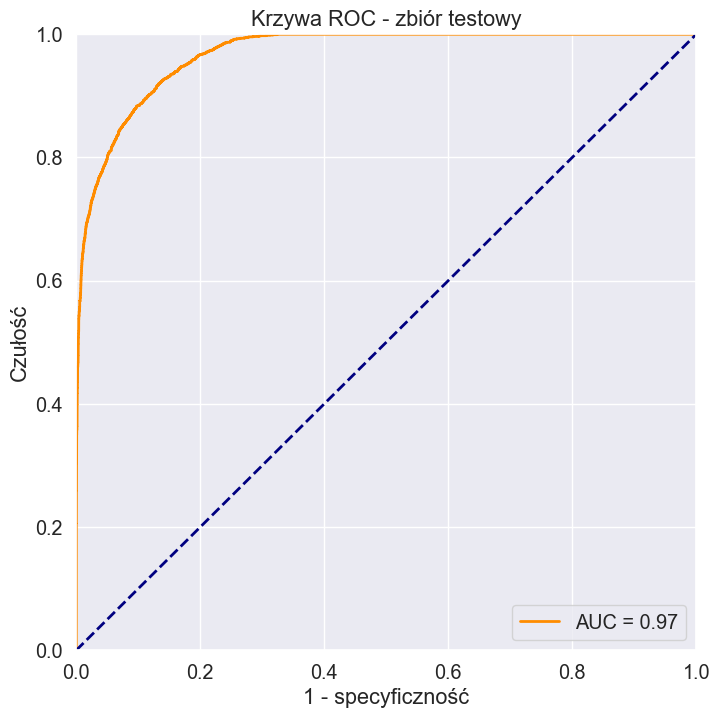

In [32]:
y_test_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob, pos_label = 1)
auc = roc_auc_score(y_test, y_test_prob)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - specyficzność')
plt.ylabel('Czułość')
plt.title('Krzywa ROC - zbiór testowy')
plt.legend(loc="lower right")
plt.show()

# XGBOOST
Zmienne katogryczne dzielimy na osobne kolumny dla kazdej wartości

In [33]:
preprocessor = ColumnTransformer(transformers =
                                [('num', 'passthrough', sel_num),
                                 ("cat", OneHotEncoder(handle_unknown = "ignore"), sel_cat)])

Tworzymy potok, który na początku wykona preprocessor, który utworzyliśmy wyżej a potem juz klasyfikator oparty o xgboost, parametry zostały dobrane dzięki grid search

In [ ]:
pipeline = Pipeline(steps = [("prep", preprocessor),
                      ("las", XGBClassifier(objective='binary:logistic', gamma=1,  max_depth=7, n_estimators=500, subsample=0.8, learning_rate=0.1, random_state=313128))])
pipeline.fit(X_train, y_train)

Uzyskujemy trafność modelu

In [ ]:
print("Trafność: ")
print("Zbiór uczący: ", pipeline.score(X_train, y_train))
print("Zbiór testowy: ", pipeline.score(X_test, y_test))

Uzyskujemy macierze pomylek dla uczącej i testowej

In [ ]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
confusion_matrix_test = confusion_matrix(y_train, y_train_pred)
confusion_matrix_train = confusion_matrix(y_test, y_test_pred)
print("Macierze pomyłek: ")
print("Zbiór uczący: ")
print(pd.DataFrame(confusion_matrix_test))
print("Zbiór testowy: ")
print(pd.DataFrame(confusion_matrix_train))

Wyznaczamy tp, tn, fp, fn

In [ ]:
tn_train, fp_train, fn_train, tp_train = confusion_matrix_train.ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix_test.ravel()

Uzyskujemy czułość modelu

In [ ]:
sensitivity_train = tp_train/(tp_train + fn_train)
sensitivity_test = tp_test/(tp_test + fn_test)
print("Czułość: ")
print("Zbiór uczący: ", sensitivity_train)
print("Zbiór testowy: ", sensitivity_test)

Uzyskujemy swoistość modelu

In [ ]:
print("Swoistość: ")
print("Zbiór uczący: ", tn_train/(tn_train + fp_train))
print("Zbiór testowy: ", tn_test/(tn_test + fp_test))

Uzyskujemy precyzje modelu

In [ ]:
precision_train = tp_train/(tp_train + fp_train)
precision_test = tp_test/(tp_test + fp_test)
print("Precyzja: ")
print("Zbiór uczący: ", precision_train)
print("Zbiór testowy: ", precision_test)

Uzyskujemy f1 modelu

In [ ]:
print("F1: ")
print("Zbiór uczący: ", 2*sensitivity_train*precision_train/(sensitivity_train + precision_train))
print("Zbiór testowy: ", 2*sensitivity_test*precision_test/(sensitivity_test + precision_test))

Wyświetlenie wykresu ważności cech

In [ ]:
importances = pipeline["las"].feature_importances_
plt.figure(figsize=(15,5))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), pipeline["prep"].get_feature_names_out())
plt.xlabel('Ważność cech')
plt.show()

Uzyskujemy krzywą roc wraz z auc dla zbioru uczącego

In [ ]:
y_train_prob = pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label = 1)
auc = roc_auc_score(y_train, y_train_prob)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - specyficzność')
plt.ylabel('Czułość')
plt.title('Krzywa ROC - zbiór uczący')
plt.legend(loc="lower right")
plt.show()

Uzyskujemy krzywą roc wraz z auc dla zbioru testowego

In [ ]:
y_test_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob, pos_label = 1)
auc = roc_auc_score(y_test, y_test_prob)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1 - specyficzność')
plt.ylabel('Czułość')
plt.title('Krzywa ROC - zbiór testowy')
plt.legend(loc="lower right")
plt.show()